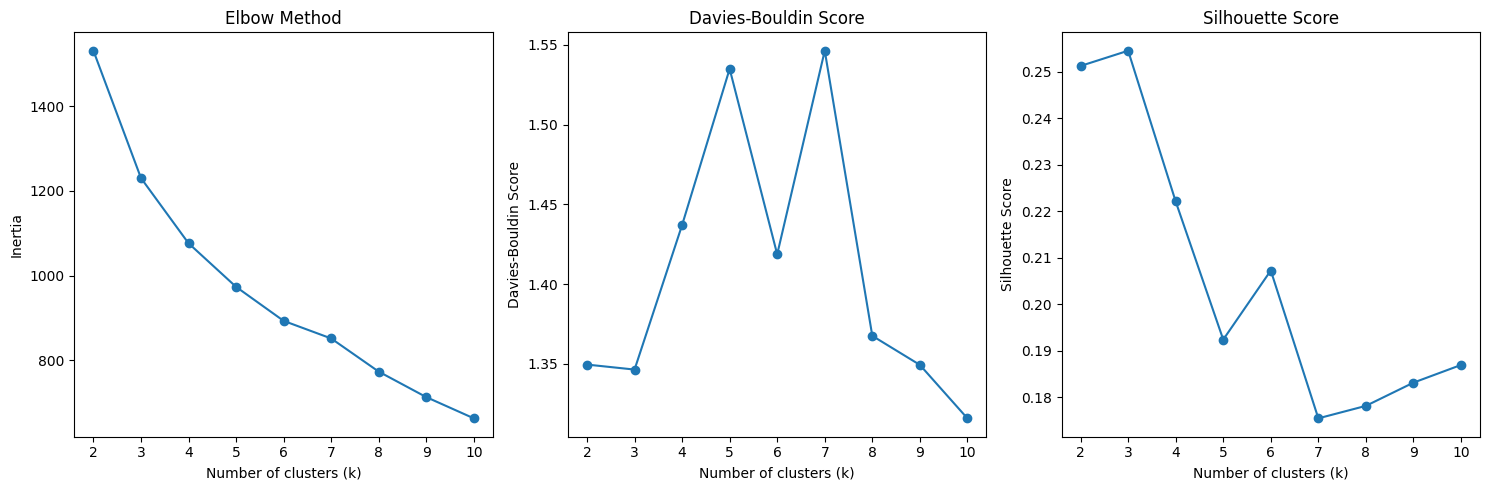

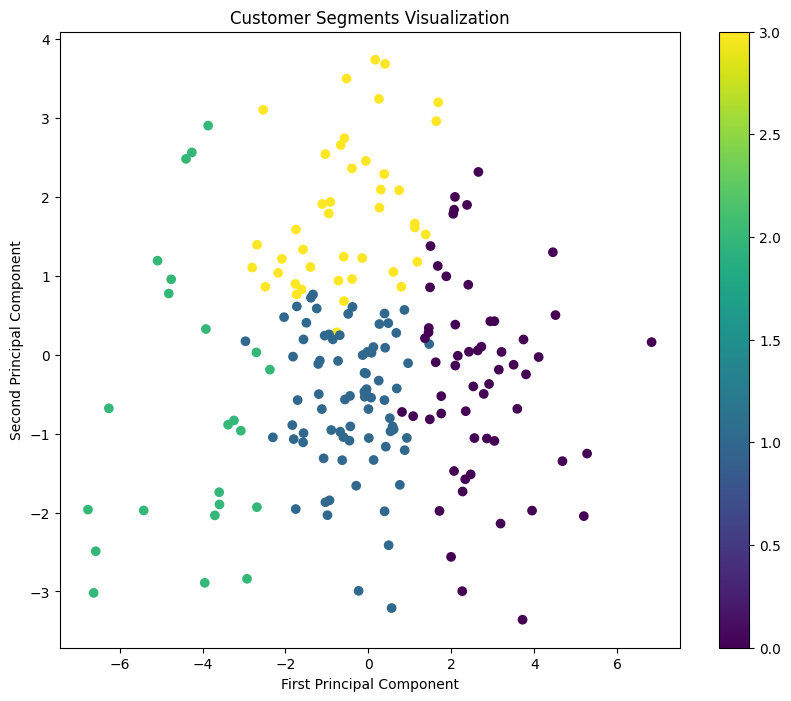


Clustering Results:
Number of clusters: 4
Davies-Bouldin Index: 1.4370
Silhouette Score: 0.2221

Cluster Sizes:
0    57
1    77
2    23
3    42
Name: count, dtype: int64

Cluster Profiles (normalized values):
         TransactionID_count  TotalValue_sum  TotalValue_mean  TotalValue_std  \
Cluster                                                                         
0                       1.05            1.23             0.48            0.42   
1                       0.02           -0.36            -0.51           -0.05   
2                      -1.30           -1.46            -1.15           -1.65   
3                      -0.76           -0.22             0.91            0.43   

         Quantity_sum  Quantity_mean  Price_mean  Price_max  Recency  \
Cluster                                                                
0                1.22           0.48        0.17       0.35    -0.35   
1               -0.20          -0.39       -0.25       0.22    -0.35   
2              

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

def create_customer_features(customers_df, transactions_df):
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean'],
        'Price': ['mean', 'max']
    }).fillna(0)
    
    transaction_features.columns = ['_'.join(col).strip() for col in transaction_features.columns.values]
    
    current_date = pd.to_datetime(transactions_df['TransactionDate']).max()
    
    rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (current_date - pd.to_datetime(x).max()).days,  
        'TransactionID': 'count',  
        'TotalValue': 'sum'  
    })
    
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    
    customer_features = pd.merge(
        transaction_features,
        rfm,
        left_index=True,
        right_index=True,
        how='left'
    )
    
    return customer_features

customer_features = create_customer_features(customers_df, transactions_df)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)
scaled_features = pd.DataFrame(scaled_features, columns=customer_features.columns, index=customer_features.index)

max_clusters = 10
inertias = []
db_scores = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 3, 2)
plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')

plt.subplot(1, 3, 3)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

optimal_k = 4 
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = final_kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization')
plt.colorbar(scatter)
plt.show()

scaled_features['Cluster'] = clusters
cluster_means = scaled_features.groupby('Cluster').mean()

print("\nClustering Results:")
print(f"Number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(scaled_features.drop('Cluster', axis=1), clusters):.4f}")
print(f"Silhouette Score: {silhouette_score(scaled_features.drop('Cluster', axis=1), clusters):.4f}")

print("\nCluster Sizes:")
print(pd.Series(clusters).value_counts().sort_index())

cluster_profiles = pd.DataFrame()
for column in customer_features.columns:
    cluster_profiles[column] = scaled_features.groupby('Cluster')[column].mean()

print("\nCluster Profiles (normalized values):")
print(cluster_profiles.round(2))